In [1]:
!python -c 'import tensorflow as tf; print(tf.__version__)'
import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops._relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))

1.1.0


In [16]:
# Initialization
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import utils

# Create mini-batch for demo

img1 = utils.load_image("../../deep_learning/data/convertible.jpg")
#img2 = utils.load_image("./shihtzu_mypuppy.jpg")
img2 = utils.load_image("./on_the_phone.jpg")
img3 = utils.load_image("./tiger.jpg")

batch1_img = img1.reshape((1, 224, 224, 3))
batch1_label = np.array([1 if i == 512 else 0 for i in range(1000)])  # 1-hot result for Convertible
batch1_label = batch1_label.reshape(1, -1)

batch2_img = img2.reshape((1, 224, 224, 3))
batch2_label = np.array([1 if i == 914 else 0 for i in range(1000)])  # 1-hot result for Shih-Tzu
batch2_label = batch2_label.reshape(1, -1)

batch3_img = img3.reshape((1, 224, 224, 3))
batch3_label = np.array([1 if i == 292 else 0 for i in range(1000)])  # 1-hot result for tiger
batch3_label = batch3_label.reshape(1, -1)

batch_img = np.concatenate((batch1_img, batch2_img, batch3_img), 0)
batch_label = np.concatenate((batch1_label, batch2_label, batch3_label), 0)

batch_size = 3

In [17]:
batch_label.shape

(3, 1000)

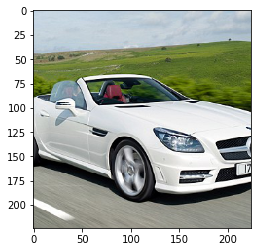

In [18]:
plt.imshow(img1)

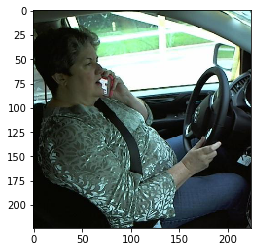

In [19]:
plt.imshow(img2)

In [20]:
# Create tensorflow graph for evaluation
from model.vgg16 import Vgg16

eval_graph = tf.Graph()
with eval_graph.as_default():
    with eval_graph.gradient_override_map({'Relu': 'GuidedRelu'}):
    
        images = tf.placeholder("float", [batch_size, 224, 224, 3])
        labels = tf.placeholder(tf.float32, [batch_size, 1000])
        train_mode = tf.placeholder(tf.bool)

        vgg = Vgg16()
        print(vgg)
        
        vgg.build(images, train_mode)
        cost = tf.reduce_sum((vgg.prob - labels) ** 2)
        train = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)

        # Get last convolutional layer gradient for generating gradCAM visualization
        target_conv_layer = vgg.pool5
        target_conv_layer_grad = tf.gradients(cost, target_conv_layer)[0]

        # Guided backpropagtion back to input layer
        gb_grad = tf.gradients(cost, images)[0]

        # Normalizing the gradients    
        target_conv_layer_grad_norm = tf.div(target_conv_layer_grad, 
                                             tf.sqrt(tf.reduce_mean(tf.square(target_conv_layer_grad))) + tf.constant(1e-5))


        init = tf.global_variables_initializer()

/home/deploy/pramit/deep_learning/Grad-CAM-tensorflow/model/vgg16.npy
npy file loaded
<model.vgg16.Vgg16 instance at 0x7f8b361ba560>
build model started
build model finished: 0s


('Top1: ', 'n03100240 convertible', 0.52713788)
('Top5: ', [('n03100240 convertible', 0.52713788), ('n04285008 sports car, sport car', 0.41532159), ('n02974003 car wheel', 0.020407254), ('n04037443 racer, race car, racing car', 0.018499877), ('n03670208 limousine, limo', 0.0073199244)])
(7, 7, 512)
(7, 7, 512)
(224, 224, 3)


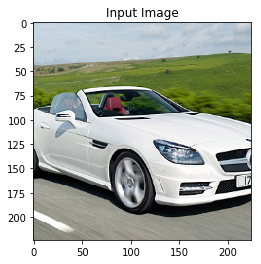

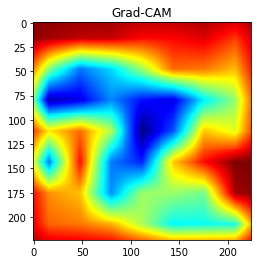

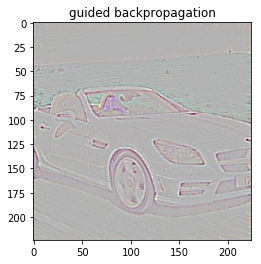

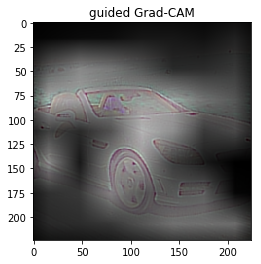

In [23]:
# Run tensorflow
with tf.Session(graph=eval_graph) as sess:    
    sess.run(init)
    
    prob = sess.run(vgg.prob, feed_dict={images: batch_img, train_mode: False})
    
    gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad_norm], feed_dict={images: batch_img, labels: batch_label, train_mode: True})
     
    i = 0
    utils.print_prob(prob[i], './synset.txt')
    print(target_conv_layer_value[0].shape)
    print(target_conv_layer_grad_value[0].shape)
    print(gb_grad_value[0].shape)
    utils.visualize(batch_img[i], target_conv_layer_value[i], target_conv_layer_grad_value[i], gb_grad_value[i])